In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

gamma = 50
alpha = 1e6

# defining the Lennard jones potential
def v(x):
    return 4*(1/x**12 - 1/x**6)

# internal part of the Schrodinger eqn, in the Numerov general form y"(t) = g(t)y
def g(x, ek):
    return gamma**2 * abs(v(x) - ek)

def returnCTPs(ek):
    #Calculating the CTPs, root_scalar returns object with execulation results, unpacking needed for actual root
    ctp_left = root_scalar(lambda x: v(x)-ek, method='secant', x0=1.0, x1=1.0 + 1e-4)
    ctp_right = root_scalar(lambda x: v(x)-ek, method='secant', x0=1.25, x1=1.25 + 1e-4)

    xa = ctp_left.root
    xb = ctp_right.root
    
    return xa,xb

def return_limits_for_E(ek):
    xa, xb = returnCTPs(ek)
    
    xs = root_scalar(
            lambda x: np.sqrt(g(x,ek)) * (xa - x) - np.log(alpha),
            bracket=[0.1,3],
            method='bisect',
        )
        # applying the same for end limit
        # func: sqrt{g(xe)} (xe-xb) ln A
    xe = root_scalar(
            lambda x: np.sqrt(g(x, ek)) * (x - xb) - np.log(alpha),
            bracket=[0.1,5],
            method='bisect',
        )
    xs = xs.root #unpacking the root_scalar object
    xe = xe.root
    return xs,xe

# Implement the refined explicit Numerov propagator
# re configured the numerov func for SE 
def numerov_for_SE(func,phi0, phi1, h, t):
    """
    Refined explicit Numerov propagator for solving y''(t) = g(t)y(t).
    
    Parameters:
    - func: The function g(t), such that y''(t) = g(t)y(t).
    - y0: Initial condition y(t0).
    - v0: Initial velocity y'(t0).
    - h: Step size for the numerical method.
    - t: Array of time points.
    
    Returns:
    - y: Array of dependent variable values computed using the explicit Numerov method.
    """
    y = np.zeros_like(t)
    
    y[0] = phi0 # two start points, as indicated by the setup
    y[1] = phi1  

    for n in range(1, len(t) - 1):
        # Compute coefficients a, b, c
        g_n = func(t[n])
        g_n_minus_1 = func(t[n - 1])
        g_n_plus_1 = func(t[n + 1])

        a = 2 + (5 / 6) * g_n * h**2
        b = 1 - (1 / 12) * g_n_minus_1 * h**2
        c = 1 - (1 / 12) * g_n_plus_1 * h**2

        # Update y[n+1] explicitly
        y[n + 1] = (a * y[n] - b * y[n - 1]) / c

    return y

# Define the Stormer-Verlet function
def stormer_verlet(f, phi0, phi1, h, t):
    """
    Implements the Stormer-Verlet algorithm for solving second-order ODEs.

    Parameters:
    - f: Function to compute the second derivative, f(t, y)
    - phi0: Initial val of the wavefunc
    - phi1: value at second position
    - t_array: Array of time points
    - dt: Time step size

    Returns:
    - y_values: Array of positions at each time step
    """
    # Number of time steps
    n_steps = len(t)

    # Initialize the array to store solutions
    y = np.zeros(n_steps)
    y[0] = phi0  # Initial values, provided as 0 and 1 for the start values
    y[1] = phi1 
    
    v = np.zeros_like(t)
    v[0] = 0

    # Perform the Stormer-Verlet iteration
    for n in range(1, n_steps - 1): 
        
        # 
        y[n + 1] = 2 * y[n] - y[n - 1] + f(t[n], y[n]) * h**2
        # Velocity update (central difference)
        v[n] = (y[n+1] - y[n-1]) / (2 * h)
    # Estimate final velocity
    v[-1] = (y[-1] - y[-2]) / h

    return y

def g_for_SE(x,ek):
    return gamma**2 * (v(x) - ek)
   
# the stormer verlett uses a different general function definition.
def g_for_SE_SV(x, ek, phi): 
    return (gamma**2 * (v(x) - ek)) * phi 

Since we are creating the plot for only a specific case (k=5), we now compute it as follows

In [ ]:
# func returns the energy levels corresponding to the array of step sizes,
# default values given to ensure computation
def return_energy_levels(method='numerov', dx_sizes = [0.01,]):
    energy = []
    dx_sizes = [ 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, ]

    for dx in dx_sizes:
        
        # # defining the x-grid
        # dx from loop
        x = np.arange(0.99, 3, dx)
        vx = [v(i) for i in x ]
        
        
        iter = 1
        k= 5 # as the question mentions
        e_upper = 0
        e_lower = -1.0

        phi_x_e_prev = 0 # for comparison, follows below

        while iter <= 100:
            e_mid = (e_upper + e_lower)/2
            
            
            # making calculations for current value of e_mid
            xs, xe = return_limits_for_E(e_mid)
            # dx = 0.001
            x_range = np.arange(xs-dx, xe+dx, dx)
            
            if method=='numerov':
                phi = numerov_for_SE(
                    lambda x: g_for_SE(x,e_mid),
                    phi0 = 0,
                    phi1 = 1,
                    h=dx,
                    t=x_range
                )
            elif method=='stormer-verlet':
                phi = stormer_verlet(
                lambda x, phi: g_for_SE_SV(x, e_mid, phi),
                0,
                1,
                dx,
                x_range
                )
            
            # calculating the nodes in the computed phi
            nodes = 0
            for i in range(0, phi.size-1):
                if(phi[i]*phi[i+1] < 0):
                    nodes = nodes + 1 
            
            
            # adjust the energy as per the node information
            if nodes > k:
                e_upper = e_mid
            else:
                e_lower = e_mid
            
            # termination if convergence is reached. Tolerance low here as the wavefn has not been normalised. After normalisation, phi[xe] will be orders of magnitude smaller
            if k == nodes and abs(phi[-1])<1e-6:     
                break
            
            # if tolerance is not hit, but the code hits numerical limit and starts to repeat the calculations
            if nodes == k and abs(phi_x_e_prev - phi[-1]) < 1e-12:
                break
            
            phi_x_e_prev = phi[-1] # to save the calculation of this iteration for comparison in the next 
            iter = iter + 1

        # normalisation of the wavefunction
        phi = phi / np.sqrt(np.dot(phi,phi))
        ek = e_mid # as, this is the root

        
        energy.append(ek)
        
    return energy
    


In [8]:
import pandas as pd
pd.set_option('display.precision', 15)

steps = [ 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, ]

numerov_energies = return_energy_levels(method='numerov',dx_sizes=steps)
stormer_verlet_energies = return_energy_levels(method='stormer-verlet',dx_sizes=steps)

df = pd.DataFrame({'Step size': steps, 'Numerov energies':numerov_energies, 'Stormer-Verlet energies':stormer_verlet_energies})
df

,Step size,Numerov energies,Stormer-Verlet energies
0,0.1000,-0.132867302719621,-0.151776985722725
1,0.0500,-0.319466847835602,-0.339089100965768
2,0.0100,-0.215652807627821,-0.217983340524271
3,0.0050,-0.215635061439762,-0.216215078015649
4,0.0010,-0.215633885244586,-0.215657053584861
5,0.0005,-0.215633882977330,-0.215639674811649
6,0.0001,-0.215633882406758,-0.215634114077118


Text(0.5, 0, 'Decreasing step sizes(or, increasing integration steps) --->')

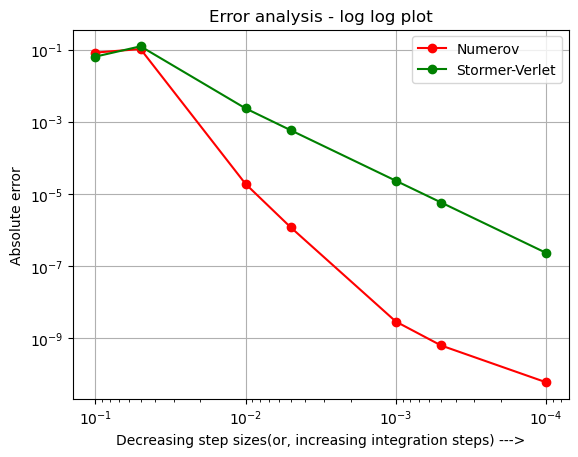

In [9]:
# now we have the list of energies corresponding to each of the step size
# in order to calculate the error, we consider the energy with the finest step size as the exact one. )
# h =0.00005 used

e_exact = -0.2156338823466465
error_numerov = [abs(e-e_exact) for e in df['Numerov energies']]
error_sv = [abs(e-e_exact) for e in df['Stormer-Verlet energies']]


plt.plot(steps, error_numerov, "-or",label = "Numerov")
plt.plot(steps,error_sv, "-og",label = "Stormer-Verlet")
plt.title("Error analysis - log log plot")
plt.yscale("log")
plt.xscale("log")
plt.gca().invert_xaxis()  # gca() gets the current axis
plt.ylabel("Absolute error")
plt.legend()
plt.grid()
plt.xlabel("Decreasing step sizes(or, increasing integration steps) --->")
